In [72]:
# - compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [73]:
# - show figures inside the notebook
%matplotlib inline

In [74]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package
import nibabel as nib

In [75]:
# - set defaults for plotting
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

Load the image `ds114_sub009_t2r1.nii` with nibabel.  Get the data:

In [76]:
# Load the image 'ds114_sub009_t2r1.nii' with nibabel
img = nib.load('ds114_sub009_t2r1.nii')
# Get the data array from the image
data = img.get_data()
data.shape

(64, 64, 30, 173)

As you remember, the first volume in this dataset is a lot different from the rest, and this will mess up our interpolation in time.

So, we need to remove the first volume from the data first, using slicing:

In [77]:
# Remove the first volume by slicing
good_data = data[..., 1:]

We start off with example time-courses from the first and second slice.

Use slicing to get a z slice 0 time series for an example voxel at voxel coordinates (23, 19, 0).

Do the same for a z slice 1 time series from (23, 19, 1).

Plot these time series against volume number (TR number) on the same graph:

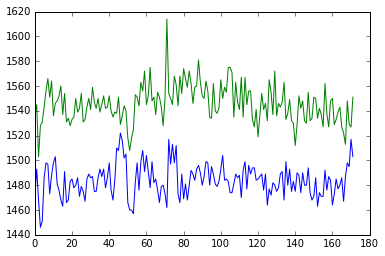

In [78]:
# Slice out time series for voxel (23, 19, 0)
voxel_0_timecourse = good_data[23,19,0,:]
# Slice out time series for voxel (23, 19, 1)
voxel_1_timecourse = good_data[23,19,1,:]
# Plot both these time series against volume number, on the same graph
plt.plot(voxel_0_timecourse,'b-')
plt.plot(voxel_1_timecourse,'g-')

The scanner collected slices for these data in an "ascending interleaved" order.  That is, the scanner first collected z slice 0, then z slice 2, up to z slice 28.  It then went back to collect z slice 1, 3, 5 up to z slice 29.

That means the scanner started collecting slice 0 in each volume, at the beginning of the TR.

The TR is 2.5 seconds.

In [79]:
# - the time between scans
TR = 2.5

Make a time vector, length 172, that corresponds to the start time in seconds of each volume.  This also gives the slice 0 start times.

In [80]:
# Make time vector containing start times in second of each volume,
# relative to start of first volume.
# Call this `slice_0_times`
slice_0_times = TR*np.arange(172)

The scanner starts to collect z slice 1 exactly half way through the TR.  Make a new vector that is the start time of acquisition of slice 1.

In [81]:
# Make time vector containing start times in seconds of z slice 1,
# relative to start of first volume.
# Call this `slice_1_times`
slice_1_times = TR*np.arange(172) + TR/2

Now plot the first 10 values for the slice 0 times, against the first 10 values of the slice 0 time series.

To the same plot for the first 10 values of the slice 1 times, against the first 10 values of the slice 1 time series.

Use the `:+` line marker for the plots to get the actual position of the points, and dotted lines betweeen them.

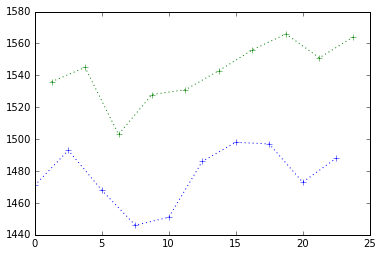

In [82]:
# Plot first 10 values of slice 0 times against first 10 of slice 0 time series
# Plot first 10 values of slice 1 times against first 10 of slice 1 time series
# Use ':+' marker
plt.plot(slice_0_times[0:10],voxel_0_timecourse[0:10],'b:+')
plt.plot(slice_1_times[0:10],voxel_1_timecourse[0:10],'g:+')

Import `InterpolatedUnivariateSpline` from `scipy.interpolate`.  Make a new linear (`k=1`) interpolation object for slice 1, with the slice 1 times and values.

In [83]:
# Import `InterpolatedUnivariateSpline` from `scipy.interpolate`
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
# Make a new linear (`k=1`) interpolation object for slice 1, with slice 1 times and values.
interp = IUS(slice_1_times, voxel_1_timecourse, k=1)

Call the object you got with the slice 0 times, to get the estimated time series values for slice 1, if slice 1 had been collected at the same time as slice 0:

In [84]:
# Call interpolator with `slice_0_times` to get estimated values
voxel_1_timecourse_est = interp(slice_0_times)

Repeat the plot of the first 10 values of the time series.  This time, on the same plot, add the estimated values for slice 1, if they had been collected at the same time as slice 0.  Use a black `x` for the estimated points (marker `kx'`):

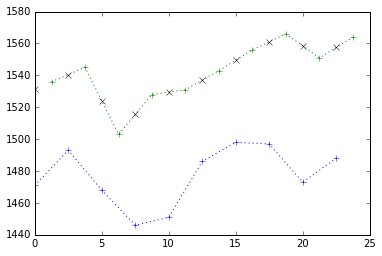

In [85]:
# Plot first 10 values of slice 0 times against first 10 of slice 0 time series
# Plot first 10 values of slice 1 times against first 10 of slice 1 time series
# Plot first 10 values of slice 0 times against first 10 of interpolated slice 1 time series
plt.plot(slice_0_times[0:10],voxel_0_timecourse[0:10],'b:+')
plt.plot(slice_1_times[0:10],voxel_1_timecourse[0:10],'g:+')
plt.plot(slice_0_times[0:10],voxel_1_timecourse_est[0:10],'kx')

Make a new data matrix to contain the slice time corrected values for all voxels.  We want to keep the values for z slice 0 unchanged, so make the new data matrix by copying the old one (and therefore getting the slice 0 values):

In [86]:
# Copy old data to a new array
new_data = good_data.copy()

Loop over every x voxel coordinate, and then loop over every y voxel coordinate.

For each x, y voxel coordinate:

* extract the time series at this x, y coordinate for slice 1;
* make a linear interpolator object with the slice 1 times and the extracted time series;
* resample this interpolator at the slice 0 times;
* put this new resampled time series into the new data at the same position

In [87]:
# loop over all x coordinate values
for x in range(good_data.shape[0]):
    # loop over all y coordinate values
    for y in range(good_data.shape[1]):
        # extract the time series at this x, y coordinate for slice 1;
        current_timecourse = good_data[x,y,1,:]
        # make a linear interpolator object with the slice 1 times and the extracted time series;
        current_interp = IUS(slice_1_times, current_timecourse, k=1)
        # resample this interpolator at the slice 0 times;
        current_timecourse_estimate = current_interp(slice_0_times)
        # put this new resampled time series into the new data at the same position
        new_data[x,y,1,:] = current_timecourse_estimate

Now we need to do the same thing for all the z slices.

To do this, we want to construct an offset vector (call it `time_offset`) of length (number of z slices) such that adding the `time_offset[z]` to the acquisition time of the the first slice will give us the time of acquisition of slice `z`.  The next few steps are to get to that `time_offset` vector.

First, make a new vector `acquisition_order` that is length 30, where `acquisition_order[i]` is the order of acquisition of slice index `i`.  For example, the first 4 elements of `acqusition_order` should be 0, 15, 1, 16.

In [88]:
# Make acquisition_order vector, length 30, with values:
# 0, 15, 1, 16 ... 14, 29
first_half = np.arange(0,15)
second_half = np.arange(15,30)
acquisition_order = np.array([])
for i in first_half:
    acquisition_order = np.append(acquisition_order,first_half[i])
    acquisition_order = np.append(acquisition_order,second_half[i])
acquisition_order

array([  0.,  15.,   1.,  16.,   2.,  17.,   3.,  18.,   4.,  19.,   5.,
        20.,   6.,  21.,   7.,  22.,   8.,  23.,   9.,  24.,  10.,  25.,
        11.,  26.,  12.,  27.,  13.,  28.,  14.,  29.])

Divide the acquisition order vector by number of slices, and multiply by the TR, to get the time offset for each z slice, relative to the start of the scan:

In [89]:
# Divide acquisition_order by number of slices, multiply by TR
time_offset = acquisition_order/acquisition_order.shape * TR
time_offset

array([ 0.        ,  1.25      ,  0.08333333,  1.33333333,  0.16666667,
        1.41666667,  0.25      ,  1.5       ,  0.33333333,  1.58333333,
        0.41666667,  1.66666667,  0.5       ,  1.75      ,  0.58333333,
        1.83333333,  0.66666667,  1.91666667,  0.75      ,  2.        ,
        0.83333333,  2.08333333,  0.91666667,  2.16666667,  1.        ,
        2.25      ,  1.08333333,  2.33333333,  1.16666667,  2.41666667])

Now we can do our whole slice time correction, for every slice.

* For each z coordinate (slice index):
    * Make a time vector by adding the slice time offset for this slice, to the slice_0 times.  Call this the `slice_z_times` vector;
    * For each x coordinate:
        * For each y coordinate:
            * extract the time series at this x, y, z coordinate;
            * make a linear interpolator object with the `slice_z_times` and the extracted time series;
            * resample this interpolator at the slice 0 times;
            * put this new resampled time series into the new data at the same position

In [90]:
# For each z coordinate (slice index):
for z in range(good_data.shape[2]):
    # Make `slice_z_times` vector for this slice
    slice_z_times = slice_0_times + time_offset[z]
    # For each x coordinate:
    for x in range(good_data.shape[0]):
        # For each y coordinate:
        for y in range(good_data.shape[1]):
            # extract the time series at this x, y, z coordinate;
            current_timecourse = good_data[x,y,z,:]
            # make a linear interpolator object with the `slice_z_times` and the extracted time series;
            current_interp = IUS(slice_z_times, current_timecourse, k=1)
            # resample this interpolator at the slice 0 times;
            current_timecourse_estimate = current_interp(slice_0_times)
            # put this new resampled time series into the new data at the same position
            new_data[x,y,z,:] = current_timecourse_estimate

Congratulations - you have just done slice timing correction on this 4D image.